In [1]:
import numpy as np
import pandas as pd
import numexpr

In [2]:
import geopandas as gpd
import pandas as pd
from shapely.ops import unary_union
from shapely.validation import make_valid

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.ops import unary_union
from shapely.geometry import Point, MultiPoint
import matplotlib.pyplot as plt

# Lotes Irregulares na base do IPTU

De acordo com o estudo sobre as ocupações em São Paulo feito pela prefeitura de São Paulo de 2021, existem 445.112 domicílios em favelas e 385.080 em loteamentos irregulares.  Por causa disso, é possível verificar no código a baixo que não são todos os imóveis registrados pelo censo de 2022 que são contribuintes do IPTU. Dessa forma, a estimativa de preço pode não ser totalmente verdadeira de acordo com o valor venal por existir falta de dados.

## Bases de dados
### Distrito de São Paulo

In [4]:
distrito = gpd.read_file("dados/SIRGAS_SHP_distrito/SIRGAS_SHP_distrito/SIRGAS_SHP_distrito.shp")
distrito = distrito.set_crs(epsg=31983)  
distrito = distrito.to_crs(epsg=31983)

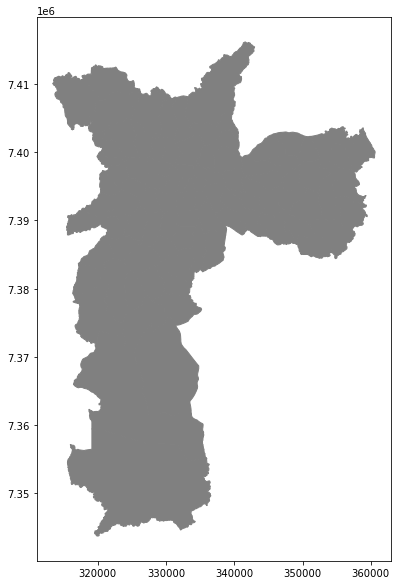

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
distrito.plot(ax=ax, color="gray", edgecolor="gray")
plt.show()


### Favelas

In [6]:
favelas = gpd.read_file("dados/irregulares/SIRGAS_SHP_favela/SIRGAS_SHP_favela.shp")
favelas = favelas.set_crs(epsg=31983, inplace=True)  
favelas = favelas.to_crs(epsg=31983)

### Lotes Irregulares

In [7]:
lotes_irregulares = gpd.read_file("dados/irregulares/SIRGAS_SHP_loteamento/SIRGAS_SHP_loteamento.shp")
lotes_irregulares = lotes_irregulares.set_crs(epsg=31983, inplace=True)  
lotes_irregulares = lotes_irregulares.to_crs(epsg=31983)
lotes_irregulares["geometry"] = lotes_irregulares["geometry"].apply(make_valid) 

### setores censitários
arquivo shapefile

In [8]:
censo_shp = gpd.read_file("dados/SP_Malha_Preliminar_2022/SP_Malha_Preliminar_2022.shp")
censo_shp = censo_shp[censo_shp["CD_MUN"] == "3550308"]
censo_shp = censo_shp.to_crs(epsg=31983)
censo_shp = censo_shp[["CD_SETOR", "geometry"]].rename(columns={"CD_SETOR": "id_setor_censitario"})
censo_shp["area_setor"] = censo_shp.geometry.area

excel

In [9]:
censo_excel = pd.read_excel("dados/Agregados_preliminares_por_setores_censitarios_SP.xlsx", usecols=["CD_SETOR", "v0001", "v0002"])
censo_excel = censo_excel.rename(columns={"CD_SETOR": "id_setor_censitario"})

junção

In [10]:
censo = censo_shp.merge(censo_excel, on="id_setor_censitario", how="left")

### IPTU vs Censo

In [11]:
valores_sc = gpd.read_file("dados/valores_sc/valores_sc.shp")
valores_sc = valores_sc.to_crs(epsg=31983)
valores_sc = valores_sc.rename(columns={"id_str_": "id_setor_censitario","unidads":"unidades"})

In [12]:
IPTU_censo = gpd.read_file("dados/IPTU_censo/IPTU.censo.shp")
IPTU_censo = IPTU_censo.set_crs(epsg=31983, inplace=True)  
IPTU_censo = IPTU_censo.to_crs(epsg=31983)
IPTU_censo = IPTU_censo.rename(columns={"id_str_": "id_setor_censitario","resdncl":"residencial","unidads":"unidades"})

## Quantidade de Unidades

In [13]:
import pandas as pd
import plotly.graph_objects as go

# Criar DataFrame
dados = {
    "Fonte de Dados": ["IPTU", "Censo"],
    "Número Total de Unidades": [
        valores_sc["unidades"].sum(skipna=True),  
        censo["v0002"].sum(skipna=True)
    ]
}
df = pd.DataFrame(dados)

# Criar tabela interativa
fig = go.Figure(data=[go.Table(
    header=dict(values=df.columns,
                fill_color="darkblue",
                font=dict(color="white", size=14),
                align="center"),
    cells=dict(values=[df[col] for col in df.columns],
               fill_color="lightgray",
               font=dict(size=12),
               align="center"))
])

# Adicionar título
fig.update_layout(title="Valores Totais de Unidades<br><sup>Comparação entre IPTU e Censo</sup>",
                  title_font=dict(size=18, family="Arial", color="black"),
                  width=500, height=300)

fig.show()


## Gráfico de Densidade

c:\Users\sergi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning:

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4



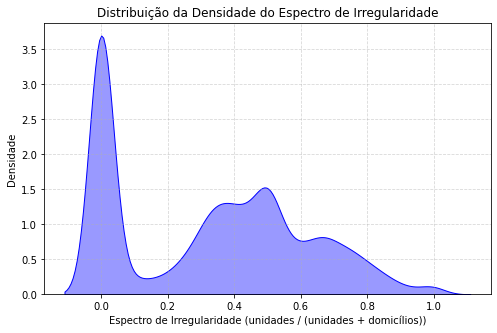

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Criar DataFrame com as colunas relevantes
censo_densidade = censo[["id_setor_censitario", "geometry", "v0002"]].rename(columns={"v0002": "domicilios"})

# Juntar com dados do IPTU
iptu_censo = IPTU_censo.drop(columns=["geometry"])  # Remover geometria
iptu_censo = iptu_censo[iptu_censo["residencial"] == 1]  # Filtrar apenas residenciais
iptu_censo = iptu_censo.groupby("id_setor_censitario", as_index=False)["unidades"].sum()

# Unir DataFrames
censo_densidade = censo_densidade.merge(iptu_censo, on="id_setor_censitario", how="left")
censo_densidade["unidades"] = censo_densidade["unidades"].fillna(0)  # Substituir valores NA por 0

# Calcular espectro de irregularidade
censo_densidade["espectro_irregularidade"] = censo_densidade["unidades"] / (censo_densidade["unidades"] + censo_densidade["domicilios"])

# Remover valores NA
censo_densidade = censo_densidade.dropna(subset=["espectro_irregularidade"])

# Criar gráfico de densidade
plt.figure(figsize=(8, 5))
sns.kdeplot(censo_densidade["espectro_irregularidade"], fill=True, color="blue", alpha=0.4)
plt.xlabel("Espectro de Irregularidade (unidades / (unidades + domicílios))")
plt.ylabel("Densidade")
plt.title("Distribuição da Densidade do Espectro de Irregularidade")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


## Mapa lotes irregulares vs IPTU

C:\Users\sergi\AppData\Local\Temp\ipykernel_14036\1599883794.py:8: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



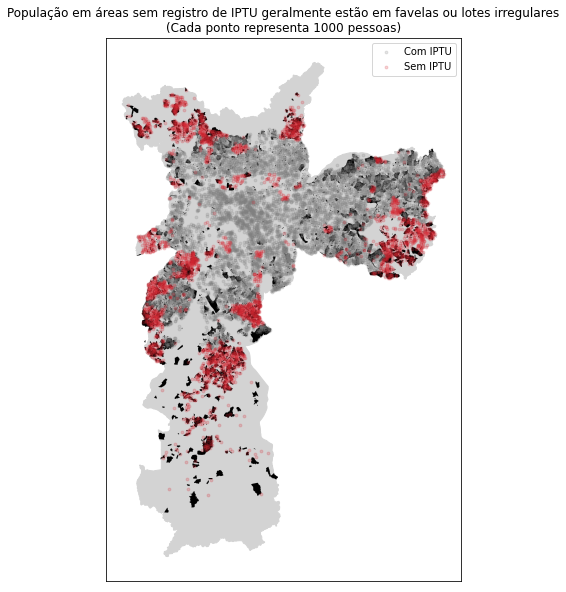

In [15]:
censo_pontos = censo[["id_setor_censitario", "geometry", "v0001"]].copy()
censo_pontos["pontos"] = censo_pontos["v0001"] // 1000 + (np.random.rand(len(censo_pontos)) * 1000 < censo_pontos["v0001"] % 1000)
censo_pontos.drop(columns=["v0001"], inplace=True)

setores_sem_iptu = censo[~censo["id_setor_censitario"].isin(valores_sc["id_setor_censitario"])]
setores_sem_iptu = setores_sem_iptu[["id_setor_censitario"]].assign(erro=True)

censo_pontos = censo_pontos.merge(setores_sem_iptu, on="id_setor_censitario", how="left").fillna({"erro": False})
censo_pontos = censo_pontos[censo_pontos["pontos"] > 0]


def gerar_amostras(geom, num_pontos):
    if geom is None or num_pontos <= 0:
        return []
    return [geom.representative_point() for _ in range(num_pontos)]  

censo_pontos["samples"] = censo_pontos.apply(lambda row: gerar_amostras(row["geometry"], int(row["pontos"])), axis=1)
censo_pontos = censo_pontos.explode("samples").drop(columns=["pontos"]).dropna().reset_index(drop=True)

# ---- PLOTAGEM ----
fig, ax = plt.subplots(figsize=(10, 10))

distrito.plot(ax=ax, color="lightgray", edgecolor="lightgray")

favelas_union = unary_union(favelas.geometry)
lote_irr_union = unary_union(lotes_irregulares.geometry)
area_irregular = unary_union([favelas_union.buffer(10), lote_irr_union.buffer(10)])
gpd.GeoSeries(area_irregular).plot(ax=ax, color="black", alpha=1, edgecolor="black", linewidth=0.1, label="Favelas e lotes irregulares")

sem_iptu = censo_pontos[censo_pontos["erro"]]
com_iptu = censo_pontos[~censo_pontos["erro"]]

ax.scatter([p.x for p in com_iptu["samples"]], [p.y for p in com_iptu["samples"]], color="gray", alpha=0.2, s=8, label="Com IPTU")
ax.scatter([p.x for p in sem_iptu["samples"]], [p.y for p in sem_iptu["samples"]], color="#D32934FF", alpha=0.2, s=8, label="Sem IPTU")

ax.set_title("População em áreas sem registro de IPTU geralmente estão em favelas ou lotes irregulares\n(Cada ponto representa 1000 pessoas)")
ax.legend()
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Regiões com Lotes Irregulares

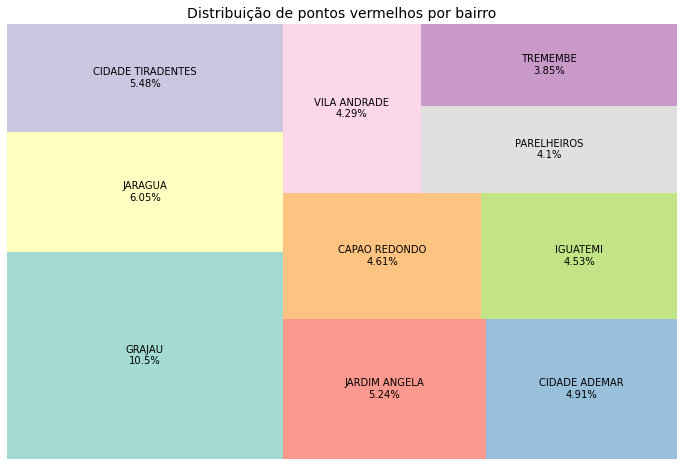

In [20]:
import geopandas as gpd
import pandas as pd
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar pontos com erro
pontos_vermelhos = censo_pontos[censo_pontos["erro"] == True].copy()

# Atribuir os pontos a cada distrito
pontos_por_distrito = gpd.sjoin(pontos_vermelhos, distrito, how="inner", predicate="intersects")
pontos_por_distrito = pontos_por_distrito.groupby("ds_nome", as_index=False).size()
pontos_por_distrito = pontos_por_distrito.rename(columns={"size": "qtd_pontos_vermelhos"})

# Ordenar para ver os distritos com mais ocorrências
pontos_por_distrito = pontos_por_distrito.sort_values(by="qtd_pontos_vermelhos", ascending=False)

# Número de bairros (ajuste conforme necessário)
num_bairros = min(10, len(pontos_por_distrito))

# Calcular percentual e rótulos
pontos_por_distrito["percentual"] = (pontos_por_distrito["qtd_pontos_vermelhos"] * 100) / pontos_por_distrito["qtd_pontos_vermelhos"].sum()
pontos_por_distrito["texto"] = pontos_por_distrito["percentual"].apply(lambda x: "<1%" if x < 1 else f"{round(x, 2)}%")
pontos_por_distrito = pontos_por_distrito.sort_values(by="qtd_pontos_vermelhos", ascending=False).head(10)


# Definir cores
palette = sns.color_palette("Set3", num_bairros)

# Criar treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=pontos_por_distrito["qtd_pontos_vermelhos"], 
              label=pontos_por_distrito["ds_nome"] + "\n" + pontos_por_distrito["texto"],
              color=palette, alpha=0.8)

# Personalizar gráfico
plt.title("Distribuição de pontos vermelhos por bairro", fontsize=14)
plt.axis("off")  # Remover eixos
plt.show()
